# Traveling Guinea Problem

## Problem Definition

Originally the problem was formulated as, a traveling salesperson needs to visit N cities. We'll formulate it as, a traveling guinea pig needs to visit N food bowls
* Can travel in a straight line between any pair of bowls
* We are given the coordinates of the bowls
* Must start and end at the same bowl
* Must visit each bowl at least once

Devise the shortest journey (in terms of total distance travelled).

This is a famous NP-hard problem (https://en.wikipedia.org/wiki/NP-hardness). We will make some simplifications:
* Flat 2-dimensional space
* Bowl locations are chosen at random within a square of unit length on each side

## Concept for our solution

We'll find the global minimum of *total distance of the route*, using simulated annealing
* Number the bowls in the order in which the guinea visits them
* Consider each bowl to be a single point (i.e. has no spatial extent)
* Denote the position of bowl i by 2D vector $r_i = (x_i, y_i)$ with $r_N = r_0$
* Start with random route
* Try swapping the order of 2 randomly-chosen bowls in the route, use Metropolis to determine whether to keep the swap
   * 'Temperature' T follows exponential cooling schedule, with time constant $\tau$ and initial temperature $T_0$
* Stop when temperature reaches $T_f$

![Newman's fig. 10.6](fig10-6.png)

### Exercise 1

Define a function to calculate the total distance travelled by the guinea over the entire journey. This is the quantity we'll be minimizing.

In [54]:
import numpy as np

# path -> set of nodes (xi, yi)
def path_length(path):
    N = len(path) # Number of nodes 
    total_dist = 0
    for i in range(1, N):
        dx = path[i][0] - path[i - 1][0]
        dy = path[i][1] - path[i - 1][1]
        total_dist += np.sqrt(dx**2 + dy**2)
    return total_dist
        
test_path = [(0,0), (10,0)]
path_length(test_path)

10.0

### Exercise 2

Write a function that randomly sets the bowl locations. It should take N as an argument, and return a 2D array (or, if you prefer, an array of 2-element vectors) containing the x and y positions of the bowls.

In [55]:
def create_nodes(N):
    N = 10 # Number of cities/bowls
    nodes = []
    for node in range(N):
        x = np.random.random()
        y = np.random.random()
        nodes.append((x,y))
    return nodes

### Exercise 3

Write a function that creates a graphical representation of the bowls' positions. It should also draw a line between each bowl i and i+1 (ideally we would have an arrow on each line, but don't bother trying to implement this.)

In [66]:
from matplotlib import pyplot as plt

N = 10
bowls = create_nodes(N)
edges = []

def plot_bowls(bowls, title):
    plt.figure()
    # Extract x and y coordinates
    x_coords, y_coords = zip(*bowls)

    # Plot the points and lines
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(x_coords, y_coords, label="Bowls") # Draw the nodes (bowls)
    plt.plot(x_coords, y_coords, linestyle='-', color='orange', label="Connections")  # Add lines (paths)

## Implementing Markov Chain with Metropolis Algorithm

### Exercise 4

Write a function that decides whether or not to perform a swap. It should take as input: the old distance (before the swap), the new distance (after the swap), and the 'temperature'. It should return something representing reject or accept.

In [57]:
def acceptanceProb(T, Di, Df):
    p = np.exp(-(1/T) * (Df - Di))
    if np.random.random() < p:
        return True
    return False

Also write a function that chooses, at random, two different bowl numbers (excluding 0 and excluding N). It should take as input how many bowls there are, and return the two chosen numbers.

In [58]:
def choose_bowls(N):
    first = None
    second = None
    while first == second:
        first = np.random.randint(1, N-1)
        second = np.random.randint(1, N-1)
    return first, second

Then write a function that tries a swap of two randomly-chosen bowls, and keeps or rejects the swap according to the Metropolis algorithm. It should take the array of bowl positions, and T, as input. It should return the new array of bowl positions (which may or may not be different from the input array).

In [64]:
def try_swap(bowls, T):
    # Current total path length
    curr_dist = path_length(bowls)

    # Choose two bowls to swap, swap them
    first, second = choose_bowls(len(bowls))
    bowls[first], bowls[second] = bowls[second], bowls[first]

    # Calculate the new path length after the swap
    new_dist = path_length(bowls)

    # Decide whether to keep the swap
    if acceptanceProb(T, curr_dist, new_dist):
        return bowls
    else:
        # Reject the swap: undo the swap
        bowls[first], bowls[second] = bowls[second], bowls[first]
        return bowls

### Exercise 5

Write code that: 
* calls your function to initialize the bowl locations
* calls your function to draw a map of the bowl locations
* prints out the total distance for the initial path
* performs the simulated annealing to minimize the distance along the path
* draws a map of the bowl locations and total distance for the solution

You should have $N,~\tau,~T_0,~T_f$ as parameters; for now, set them to the following values:

Initial Total Path Length: 4.51503
Optimized Total Path Length: 2.68632


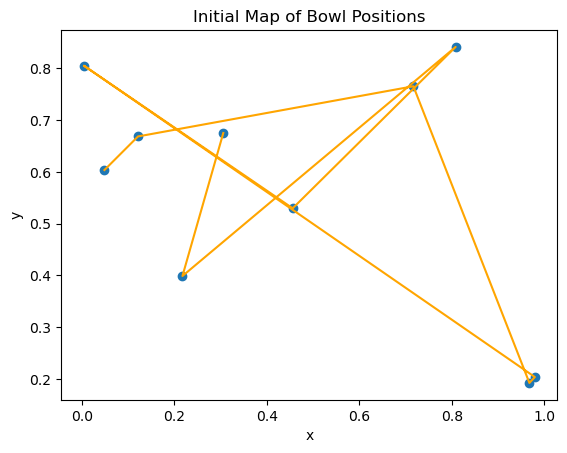

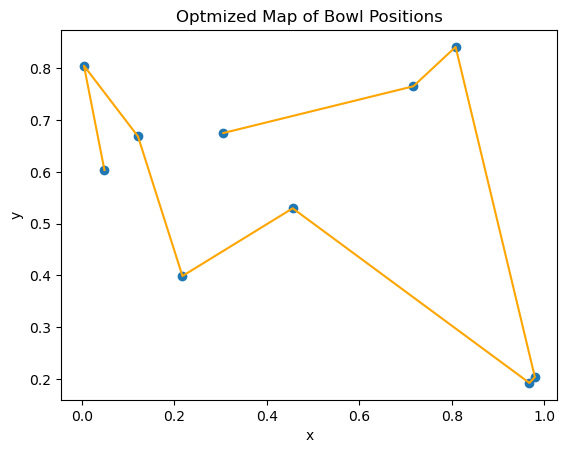

In [94]:
N = 60
tau = 1e4
T0 = 10.0
Tf = 1e-3

def simulated_annealing(bowls, T0, Tf, tau):
    T = T0
    t = 0  # Time step
    path_lengths = [path_length(bowls)]
    
    while T > Tf:
        bowls = try_swap(bowls, T)
        path_lengths.append(path_length(bowls))
        t += 1
        T = T0 * np.exp(-t / tau)  # Exponential cooling schedule

    return bowls, path_lengths

# Initialize bowls and plot initial configuration
bowls = create_nodes(N)
plot_bowls(bowls, "Initial Map of Bowl Positions")

initial_pathlen = path_length(bowls)

print(f"Initial Total Path Length: {initial_pathlen:.5f}")

# Perform simulated annealing
optimized_bowls, path_lengths = simulated_annealing(bowls, T0, Tf, tau)
print(f"Optimized Total Path Length: {optimized_pathlen:.5f}")

# Plot optimized configuration
plot_bowls(optimized_bowls, "Optmized Map of Bowl Positions")

### Exercise 6

Now modify your code to produce, along the way, two 'diagnostic' plots to get some more insight into what the algorithm is doing:
* distance vs t
* T vs t

This means your code has to keep track of distance and T at each step. 

Also make your code time how long the simulated annealing algorithm takes (not including the initialization of the bowls, and not including any plotting).

### Exercise 7

Optimized Total Path Length: 2.80633
Execution Time: 9211.00 seconds


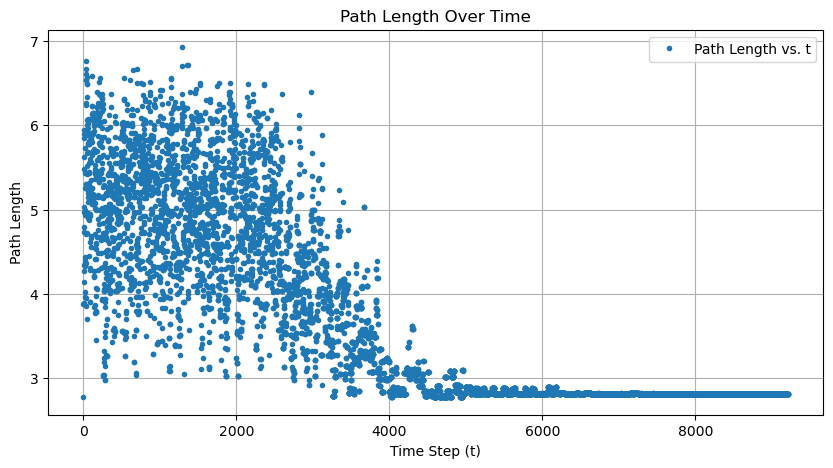

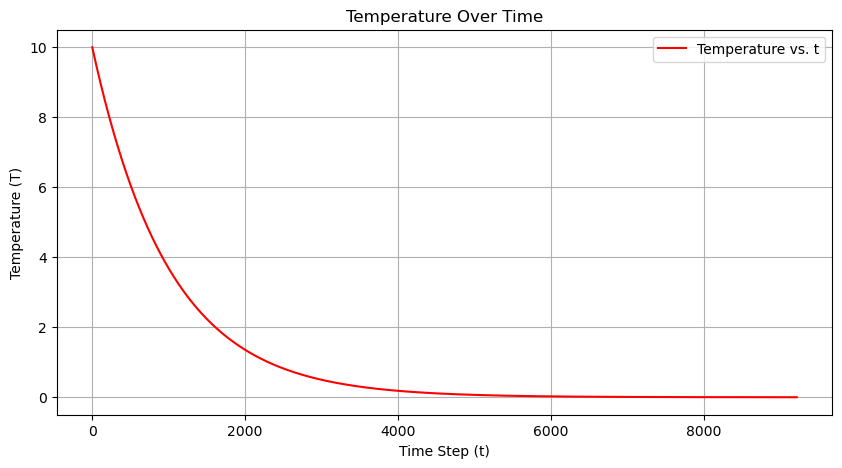

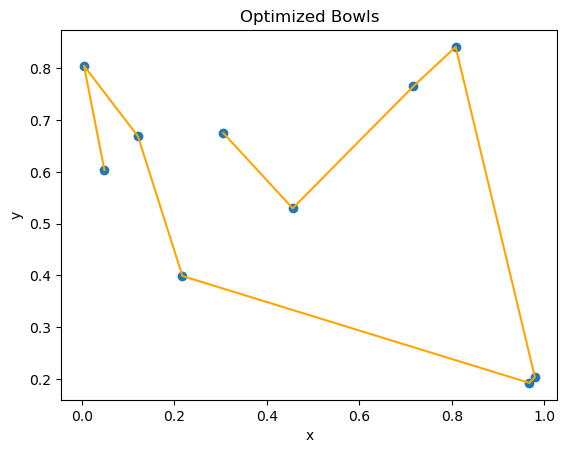

In [101]:
import time
import numpy as np
from matplotlib import pyplot as plt

def simulated_annealing_with_diagnostics(bowls, T0, Tf, tau):
    T = T0
    t = 0  # Time step
    path_lengths = [path_length(bowls)]  # Track path lengths
    temperatures = [T]  # Track temperatures

    while T > Tf:
        bowls = try_swap(bowls, T)
        path_lengths.append(path_length(bowls))
        t += 1
        T = T0 * np.exp(-t / tau)  # Exponential cooling schedule
        temperatures.append(T)

    return bowls, path_lengths, temperatures, t


# Perform simulated annealing with diagnostics
optimized_bowls, path_lengths, temperatures, execution_time = simulated_annealing_with_diagnostics(bowls, T0, Tf, tau)
optimized_pathlen = path_length(optimized_bowls)
print(f"Optimized Total Path Length: {optimized_pathlen:.5f}")
print(f"Execution Time: {execution_time:.2f} seconds")

plt.figure(figsize=(10, 5))
plt.plot(path_lengths,'.', label="Path Length vs. t")
plt.xlabel("Time Step (t)")
plt.ylabel("Path Length")
plt.title("Path Length Over Time")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(temperatures, label="Temperature vs. t", color="red")
plt.xlabel("Time Step (t)")
plt.ylabel("Temperature (T)")
plt.title("Temperature Over Time")
plt.legend()
plt.grid()
plt.show()

plot_bowls(optimized_bowls, "Optimized Bowls")


Try your code from the previous exercise with $N=40$, then $N=60$. As you increase N, do you notice the computation time going up? What about the number of steps required to reach a solution?

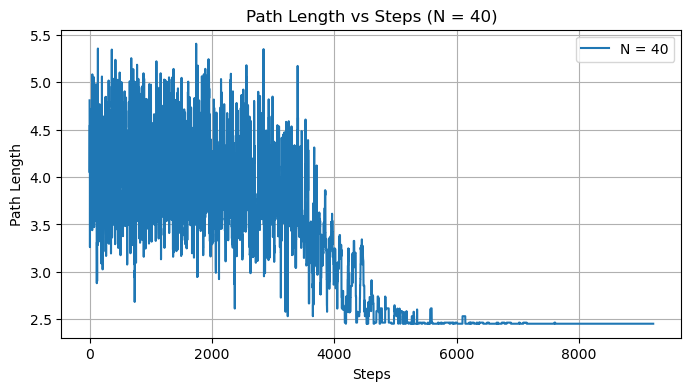

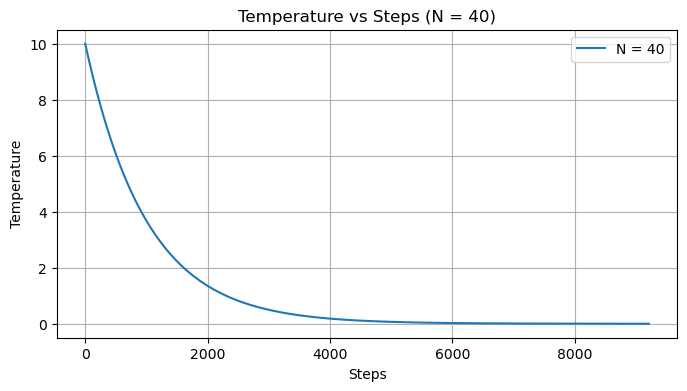

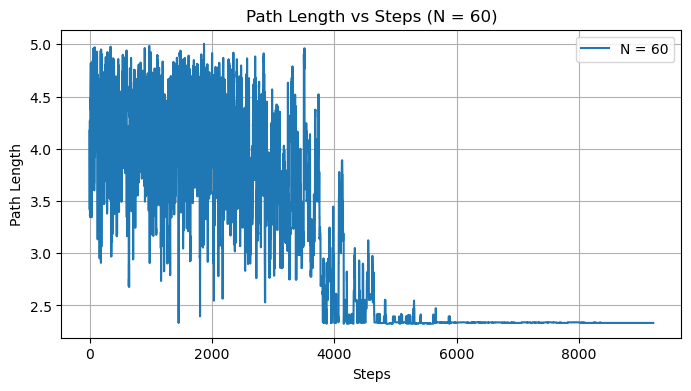

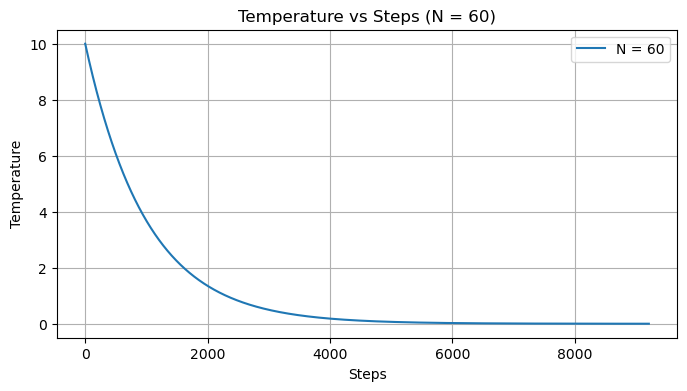

N = 40, Initial Path Length: 4.81, Final Path Length: 2.45, Steps: 9211, Execution Time: 0.32 seconds
N = 60, Initial Path Length: 4.17, Final Path Length: 2.33, Steps: 9211, Execution Time: 0.30 seconds


In [102]:
import matplotlib.pyplot as plt
from time import time  # Importing time for measuring execution duration

def run_with_different_N(N_values, T0, Tf, tau):
    results = []
    for N in N_values:
        # Generate initial bowl positions
        bowls = create_nodes(N)
        initial_pathlen = path_length(bowls)
        
        start_time = time()
        final_bowls, path_lengths, temperatures, total_steps = simulated_annealing_with_diagnostics(
            bowls, T0, Tf, tau)
        
        execution_time = time() - start_time
        
        final_pathlen = path_lengths[-1]
        
        result = {
            "N": N,
            "Initial Path Length": initial_pathlen,
            "Final Path Length": final_pathlen,
            "Steps": total_steps,
            "Execution Time (s)": execution_time,
            "Path Lengths": path_lengths,
            "Temperatures": temperatures,
        }
        results.append(result)

        # Plot Path Length vs Steps
        plt.figure(figsize=(8, 4))
        plt.plot(path_lengths, label=f'N = {N}')
        plt.xlabel("Steps")
        plt.ylabel("Path Length")
        plt.title(f"Path Length vs Steps (N = {N})")
        plt.legend()
        plt.grid()
        plt.show()
        
        # Plot Temperature vs Steps
        plt.figure(figsize=(8, 4))
        plt.plot(temperatures, label=f'N = {N}')
        plt.xlabel("Steps")
        plt.ylabel("Temperature")
        plt.title(f"Temperature vs Steps (N = {N})")
        plt.legend()
        plt.grid()
        plt.show()
    
    return results

results = run_with_different_N(N_values, T0, Tf, tau)

for result in results:
    print(f"N = {result['N']}, Initial Path Length: {result['Initial Path Length']:.2f}, "
          f"Final Path Length: {result['Final Path Length']:.2f}, Steps: {result['Steps']}, "
          f"Execution Time: {result['Execution Time (s)']:.2f} seconds")


### Exercise 8

With $N=60$, now try a few different values of $\tau: ~100,~1000,~10000$, with the same random seed each time. Does the solution itself change? What about the execution time? Can you see the trade-off between computational speed and possibility of getting stuck in local minimum?

Tau = 100, Initial Path Length: 2.91, Final Path Length: 2.91, Steps: 922, Execution Time: 0.03 seconds
Tau = 1000, Initial Path Length: 2.79, Final Path Length: 2.79, Steps: 9211, Execution Time: 0.30 seconds
Tau = 10000, Initial Path Length: 2.79, Final Path Length: 2.79, Steps: 92104, Execution Time: 3.04 seconds


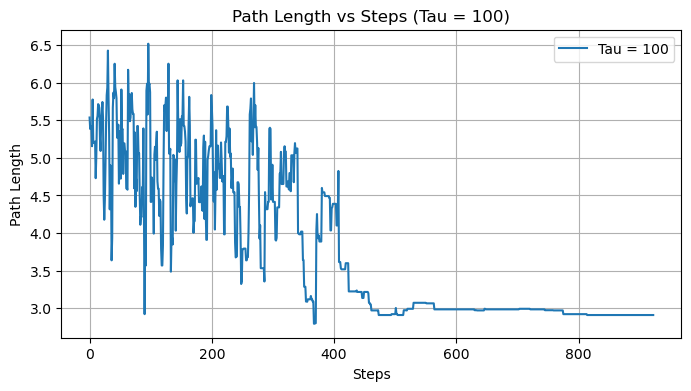

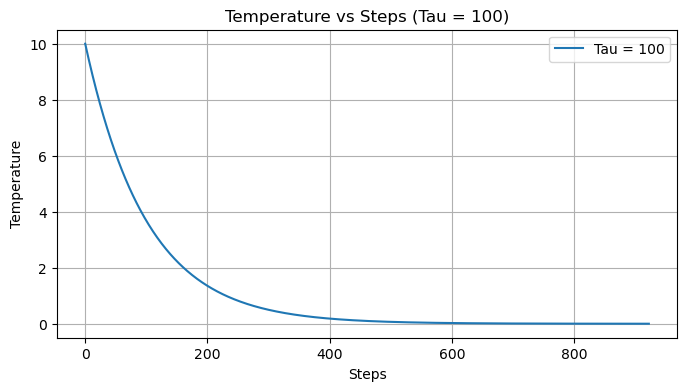

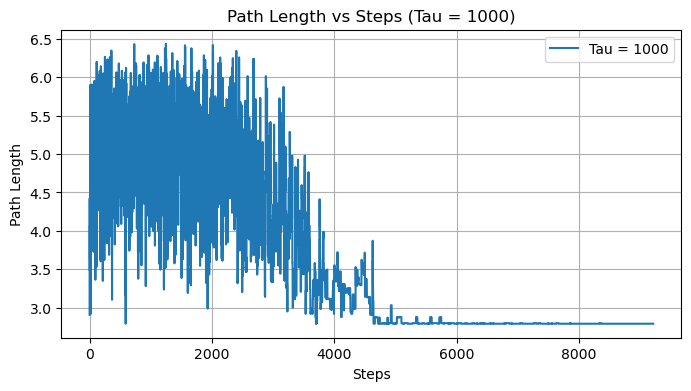

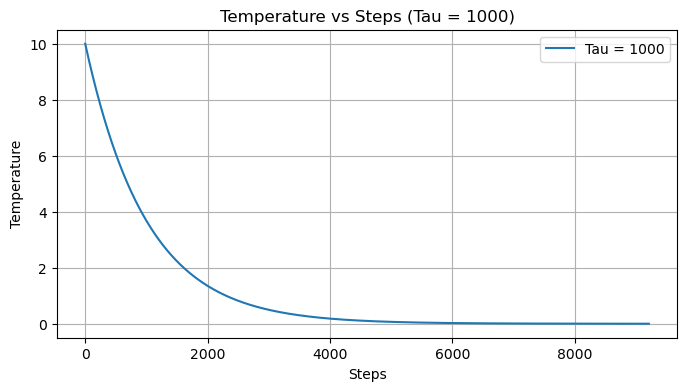

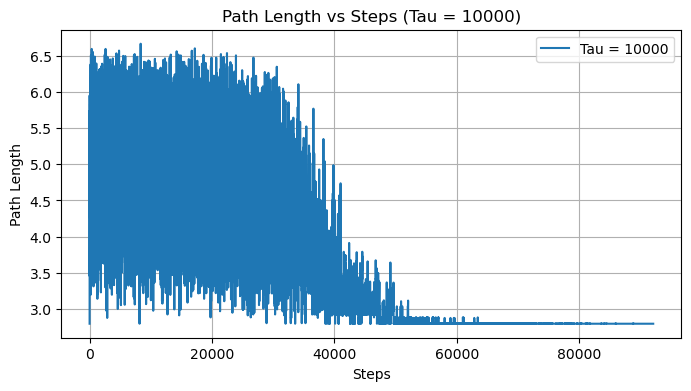

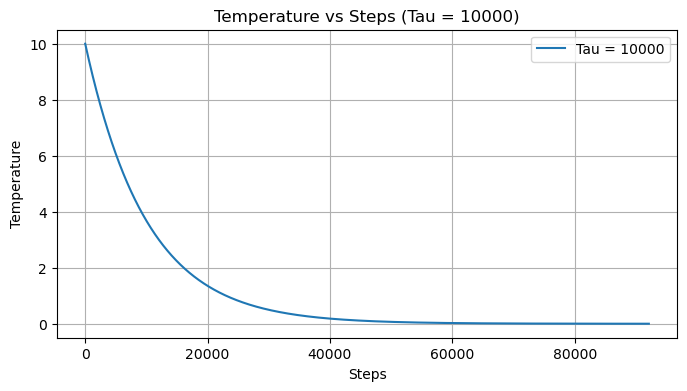

In [104]:
def run_with_different_tau(tau_values, N, T0, Tf):
    np.random.seed(42)  # Set a fixed random seed for consistent results
    results = []
    bowls = create_nodes(N)  # Create the bowl positions
    
    for tau in tau_values:
        start_time = time()
        final_bowls, path_lengths, temperatures, total_steps = simulated_annealing_with_diagnostics(
            bowls, T0, Tf, tau
        )
        execution_time = time() - start_time
        
        result = {
            "Tau": tau,
            "Initial Path Length": path_length(bowls),
            "Final Path Length": path_lengths[-1],
            "Steps": total_steps,
            "Execution Time": execution_time,
            "Path Lengths": path_lengths,
            "Temperatures": temperatures,
        }
        results.append(result)
    
    return results

results = run_with_different_tau(tau_values, N, T0, Tf)

for result in results:
    print(f"Tau = {result['Tau']}, Initial Path Length: {result['Initial Path Length']:.2f}, "
          f"Final Path Length: {result['Final Path Length']:.2f}, Steps: {result['Steps']}, "
          f"Execution Time: {result['Execution Time']:.2f} seconds")


for result in results:
    # Plot Path Length vs Steps
    plt.figure(figsize=(8, 4))
    plt.plot(result['Path Lengths'], label=f'Tau = {result["Tau"]}')
    plt.xlabel("Steps")
    plt.ylabel("Path Length")
    plt.title(f"Path Length vs Steps (Tau = {result['Tau']})")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot Temperature vs Steps
    plt.figure(figsize=(8, 4))
    plt.plot(result['Temperatures'], label=f'Tau = {result["Tau"]}')
    plt.xlabel("Steps")
    plt.ylabel("Temperature")
    plt.title(f"Temperature vs Steps (Tau = {result['Tau']})")
    plt.legend()
    plt.grid()
    plt.show()
